<a href="https://colab.research.google.com/github/Monisha2604/Final_Year_Project/blob/master/RF_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorIndexer

In [ ]:
conf = SparkConf().setAppName('RandomForest').setMaster('local[*]')
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)

In [ ]:
data=sql_context.read.csv("/content/drive/MyDrive/Copy of Final_project_processed_data.csv",inferSchema=True,header=True)


In [ ]:
data.count()

2441900

In [ ]:
data.show()

+---+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|_c0|          psfMag_u|          psfMag_g|          psfMag_r|          psfMag_i|          psfMag_z|           dered_u|           dered_g|           dered_r|           dered_i|           dered_z|        fiberMag_u|        fiberMag_g|        fiberMag_r|        fiberMag_i|        fiberMag_z|        petroR50_r|        petroR50_z|        petroR90_r|        petroR90_z|                 r|                 i|                 z|           redshift|
+---+------------------+------------------+------------------+------------------+------------------+------------

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(
    inputCols=['psfMag_u',
               'psfMag_g',
               'psfMag_r',
               'psfMag_i',
               'psfMag_z',
               'dered_u', 
               'dered_g', 
               'dered_r', 
               'dered_i', 
               'dered_z', 
               'fiberMag_u', 
               'fiberMag_g', 
               'fiberMag_r', 
               'fiberMag_i', 
               'fiberMag_z', 
               'petroR50_r', 
               'petroR50_z', 
               'petroR90_r', 
               'petroR90_z',
               'r', 
               'i', 
               'z'],
    outputCol="features"
)

In [ ]:
data=assembler.transform(data)

In [ ]:
output=data.select("features","redshift")

In [ ]:
featureIndexer=VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

In [ ]:
#type(featureIndexer)

In [ ]:
(train_df,test_df)=output.randomSplit([0.8,0.2])

In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [ ]:
transformed= transData(data)
transformed.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[0.0,24.35021,22....|0.8162744000000001|
|[1.0,24.47392,22....|         0.5564747|
|[2.0,23.38084,22....|          0.619608|
|[3.0,24.722579999...|         0.4611808|
|[4.0,25.2249,24.4...|         0.6421724|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures").fit(transformed)

df = featureIndexer.transform(transformed)
df.show(5,True)


+--------------------+------------------+--------------------+
|            features|             label|     indexedFeatures|
+--------------------+------------------+--------------------+
|[0.0,24.35021,22....|0.8162744000000001|[0.0,24.35021,22....|
|[1.0,24.47392,22....|         0.5564747|[1.0,24.47392,22....|
|[2.0,23.38084,22....|          0.619608|[2.0,23.38084,22....|
|[3.0,24.722579999...|         0.4611808|[3.0,24.722579999...|
|[4.0,25.2249,24.4...|         0.6421724|[4.0,25.2249,24.4...|
+--------------------+------------------+--------------------+
only showing top 5 rows



In [ ]:
(trainingData, testData) = df.randomSplit([0.80, 0.20]) 

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features",numTrees=50,maxDepth=10)

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages=[rf])

In [ ]:
import timeit

In [ ]:
%time
pipeline = Pipeline(stages=[featureIndexer, rf])
start = timeit.default_timer()
model = pipeline.fit(trainingData)
stop = timeit.default_timer()
print('Time: ', (stop - start)/60,'minutes')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
Time:  14.820390283999995 minutes


In [ ]:
output.show(3),train_df.show(2)

+--------------------+------------------+
|            features|          redshift|
+--------------------+------------------+
|[24.35021,22.7895...|0.8162744000000001|
|[24.47392,22.4341...|         0.5564747|
|[23.38084,22.5427...|          0.619608|
+--------------------+------------------+
only showing top 3 rows

+--------------------+----------+
|            features|  redshift|
+--------------------+----------+
|[15.2698299999999...|       0.0|
|[15.3482,15.27617...|0.03022659|
+--------------------+----------+
only showing top 2 rows



(None, None)

In [ ]:
train_df=train_df.withColumnRenamed("redshift","label")

In [ ]:
train_df.show(3),
test_df.show(2)

+--------------------+----------+
|            features|     label|
+--------------------+----------+
|[15.2698299999999...|       0.0|
|[15.3482,15.27617...|0.03022659|
|[15.38067,13.8078...|       0.0|
+--------------------+----------+
only showing top 3 rows

+--------------------+----------+
|            features|  redshift|
+--------------------+----------+
|[15.7218299999999...|0.03588414|
|[15.7410600000000...| 0.2543997|
+--------------------+----------+
only showing top 2 rows



In [ ]:
import timeit
start=timeit.default_timer()
model = pipeline.fit(train_df)
stop=timeit.default_timer()
print("time:",(stop-start)/30," mins")

time: 4.441034690733341  mins


In [ ]:
#test_df=test_df.select("features","redshift")
test_df=test_df.withColumnRenamed("redshift","label")

In [ ]:
predictions = model.transform(testData)

In [ ]:
predictions.show(5)

+--------------------+-----------+------------------+
|            features|      label|        prediction|
+--------------------+-----------+------------------+
|[15.5872299999999...|        0.0|0.0890105861998347|
|[15.7218299999999...| 0.03588414|0.0890105861998347|
|[16.07687,16.0014...|  0.1103326|0.0890105861998347|
|[16.25712,16.3869...|  0.1179971|0.0890105861998347|
|[16.31604,15.7989...|0.009996938|0.0890105861998347|
+--------------------+-----------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data = %g" % r2)

R2 on test data = 0.614903


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)

Mean Squared Error (MSE) on test data = 0.205155


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Mean Absolute Error (MAE) on test data = 0.208638


In [ ]:
import numpy as np

In [ ]:
result=predictions.toPandas()

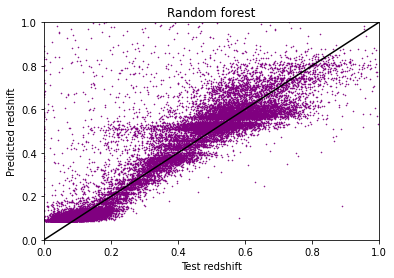

In [ ]:
import matplotlib.pyplot as plt
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.title("Random forest")
plt.scatter(result.label[:30000], result.prediction[:30000], s=0.3, color="purple")
ax1.set_xlabel("Test redshift")
ax1.set_ylabel("Predicted redshift")
ax1.plot([0,1], [0,1], '-r',color="black")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
    
plt.show() 

In [ ]:
y_test=np.array(predictions.select("label").collect())
y_pred=np.array(predictions.select("prediction").collect())

In [ ]:
y_test

array([[0.1933094],
       [0.804176 ],
       [0.162808 ],
       ...,
       [0.4489835],
       [0.4740988],
       [0.4153849]])